In [1]:
import duckdb
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = Path().resolve().parent  # adjust if needed
DB_PATH = BASE_DIR / "data" / "olist.duckdb"

con = duckdb.connect(str(DB_PATH))

df = con.execute("""
    SELECT *
    FROM order_delivery_metrics
""").fetchdf()

con.close()

df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,purchase_ts,delivered_ts,estimated_ts,delivery_days,estimated_delivery_days,delay_vs_estimate_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8,16,-8
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,14,20,-6
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9,27,-18
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,14,27,-13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,3,13,-10


In [2]:
df["delivery_days"].describe()


count    96470.000000
mean        12.496849
std          9.555071
min          0.000000
25%          7.000000
50%         10.000000
75%         16.000000
max        210.000000
Name: delivery_days, dtype: float64

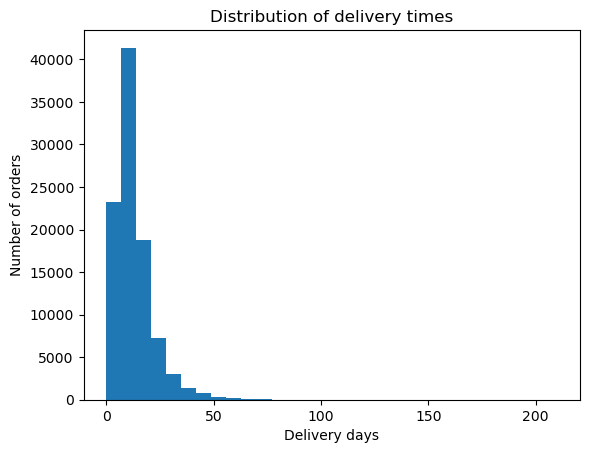

In [3]:
plt.hist(df["delivery_days"].dropna(), bins=30)
plt.xlabel("Delivery days")
plt.ylabel("Number of orders")
plt.title("Distribution of delivery times")
plt.show()


In [4]:
df["is_late"] = (df["delay_vs_estimate_days"] > 0).astype(int)
df["is_late"].value_counts(normalize=True)


is_late
0    0.932269
1    0.067731
Name: proportion, dtype: float64

In [5]:
con = duckdb.connect(str(DB_PATH))

df_reviews = con.execute("""
    SELECT
        odm.order_id,
        odm.is_late,
        r.review_score
    FROM (
        SELECT
            order_id,
            (delay_vs_estimate_days > 0) AS is_late
        FROM order_delivery_metrics
    ) odm
    JOIN order_reviews r
        ON odm.order_id = r.order_id
""").fetchdf()

con.close()

df_reviews["is_late"] = df_reviews["is_late"].astype(int)
df_reviews.head()


,order_id,is_late,review_score
0,73fc7af87114b39712e6da79b0a377eb,0,4
1,a548910a1c6147796b98fdf73dbeba33,0,5
2,f9e4b658b201a9f2ecdecbb34bed034b,0,5
3,658677c97b385a9be170737859d3511b,0,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,0,5


In [6]:
df_reviews.groupby("is_late")["review_score"].mean()


is_late
0    4.289980
1    2.271025
Name: review_score, dtype: float64